# （⬅️可折叠）函数与库

In [26]:
import os
import random
import shutil
from pathlib import Path
import numpy as np
import torch
import torchaudio
import soundfile as sf
from multiprocessing import Pool, cpu_count
import multiprocessing as mp
from silero_vad import load_silero_vad
from IPython.display import Audio
from scipy.fft import rfft, fft
import tensorflow as tf


class MFCCProcessor:
    """
    Python implementation of MFCC (Mel-Frequency Cepstral Coefficients)
    Based on the RISC-V DSP library implementation
    """
    
    def __init__(self, fft_len=256, nb_mel_filters=40, nb_dct_outputs=13, use_cfft=False):
        """
        Initialize MFCC processor
        
        Args:
            fft_len: FFT length (should match window length)
            nb_mel_filters: Number of mel filter banks
            nb_dct_outputs: Number of DCT outputs (MFCC coefficients)
            use_cfft: Whether to use CFFT instead of RFFT (default: False)
        """
        self.fft_len = fft_len
        self.nb_mel_filters = nb_mel_filters
        self.nb_dct_outputs = nb_dct_outputs
        self.use_cfft = use_cfft
        
        # Initialize coefficient arrays - to be filled with actual data
        self.window_coefs = None
        self.filter_pos = None
        self.filter_lengths = None
        self.filter_coefs = None
        self.dct_coefs = None
        
        self._load_coefficients()
    
    def _load_coefficients(self):
        """Load pre-computed coefficients"""
        
        # Hanning window coefficients (256 points)
        # TODO: Fill with mfcc_window_coefs_hann256 data
        self.window_coefs = np.array([
            # Insert mfcc_window_coefs_hann256 values here
            # Format: [0.000000, 0.000151, 0.000602, ...]
            0.000000,0.000151,0.000602,0.001355,0.002408,0.003760,0.005412,0.007361,0.009607,0.012149,
            0.014984,0.018112,0.021530,0.025236,0.029228,0.033504,0.038060,0.042895,0.048005,0.053388,
            0.059039,0.064957,0.071136,0.077573,0.084265,0.091208,0.098396,0.105827,0.113495,0.121396,
            0.129524,0.137876,0.146447,0.155230,0.164221,0.173414,0.182803,0.192384,0.202150,0.212096,
            0.222215,0.232501,0.242949,0.253551,0.264302,0.275194,0.286222,0.297379,0.308658,0.320052,
            0.331555,0.343159,0.354858,0.366644,0.378510,0.390449,0.402455,0.414519,0.426635,0.438795,
            0.450991,0.463218,0.475466,0.487729,0.500000,0.512271,0.524534,0.536782,0.549009,0.561205,
            0.573365,0.585481,0.597545,0.609551,0.621490,0.633356,0.645142,0.656841,0.668445,0.679947,
            0.691342,0.702621,0.713778,0.724806,0.735698,0.746449,0.757051,0.767499,0.777785,0.787904,
            0.797850,0.807616,0.817197,0.826586,0.835779,0.844770,0.853553,0.862124,0.870476,0.878604,
            0.886505,0.894173,0.901604,0.908792,0.915735,0.922427,0.928864,0.935044,0.940961,0.946612,
            0.951995,0.957105,0.961940,0.966496,0.970772,0.974764,0.978470,0.981888,0.985016,0.987851,
            0.990393,0.992639,0.994588,0.996240,0.997592,0.998645,0.999398,0.999849,1.000000,0.999849,
            0.999398,0.998645,0.997592,0.996240,0.994588,0.992639,0.990393,0.987851,0.985016,0.981888,
            0.978470,0.974764,0.970772,0.966496,0.961940,0.957105,0.951995,0.946612,0.940961,0.935044,
            0.928864,0.922427,0.915735,0.908792,0.901604,0.894173,0.886505,0.878604,0.870476,0.862124,
            0.853553,0.844770,0.835779,0.826586,0.817197,0.807616,0.797850,0.787904,0.777785,0.767499,
            0.757051,0.746449,0.735698,0.724806,0.713778,0.702621,0.691342,0.679947,0.668445,0.656841,
            0.645142,0.633356,0.621490,0.609551,0.597545,0.585481,0.573365,0.561205,0.549009,0.536782,
            0.524534,0.512271,0.500000,0.487729,0.475466,0.463218,0.450991,0.438795,0.426635,0.414519,
            0.402455,0.390449,0.378510,0.366644,0.354858,0.343159,0.331555,0.320052,0.308658,0.297379,
            0.286222,0.275194,0.264302,0.253551,0.242949,0.232501,0.222215,0.212096,0.202150,0.192384,
            0.182803,0.173414,0.164221,0.155230,0.146447,0.137876,0.129524,0.121396,0.113495,0.105827,
            0.098396,0.091208,0.084265,0.077573,0.071136,0.064957,0.059039,0.053388,0.048005,0.042895,
            0.038060,0.033504,0.029228,0.025236,0.021530,0.018112,0.014984,0.012149,0.009607,0.007361,
            0.005412,0.003760,0.002408,0.001355,0.000602,0.000151
        ], dtype=np.float32)
        
        # MEL filter positions (40 filters)
        # TODO: Fill with mfcc_filter_pos_mel40 data
        self.filter_pos = np.array([
            # Insert mfcc_filter_pos_mel40 values here
            # Format: [1, 2, 3, 4, 5, 6, 8, 9, ...]
            1,2,3,4,5,6,8,9,11,12,
            14,15,17,19,21,23,25,27,30,32,
            35,38,40,43,46,50,53,57,60,64,
            68,73,77,82,87,92,97,103,109,115,
        ], dtype=np.uint32)
        
        # MEL filter lengths (40 filters)
        # TODO: Fill with mfcc_filter_len_mel40 data
        self.filter_lengths = np.array([
            # Insert mfcc_filter_len_mel40 values here
            # Format: [2, 2, 2, 2, 3, 3, 3, 3, ...]
            2,2,2,2,3,3,3,3,3,3,
            3,4,4,4,4,4,5,5,5,6,
            5,5,6,7,7,7,7,7,8,9,
            9,9,10,10,10,11,12,12,13,13,
        ], dtype=np.uint32)
        
        # MEL filter coefficients
        # TODO: Fill with mfcc_filter_coefs_mel40 data
        self.filter_coefs = np.array([
            # Insert mfcc_filter_coefs_mel40 values here
            # Format: [0.940365, 0.158628, 0.841372, ...]
            0.940365,0.158628,0.841372,0.293816,0.706184,0.462403,0.537597,0.661904,0.338096,0.890104,
            0.145015,0.109896,0.854985,0.424850,0.575150,0.727995,0.052989,0.272005,0.947011,0.398503,
            0.601497,0.763326,0.146352,0.236674,0.853648,0.546566,0.453434,0.963036,0.394905,0.036964,
            0.605095,0.841380,0.301730,0.158620,0.698270,0.775275,0.261386,0.224725,0.738614,0.759477,
            0.269002,0.240523,0.730998,0.789451,0.320349,0.210549,0.679651,0.861250,0.411736,0.138750,
            0.588264,0.971416,0.539920,0.116902,0.028584,0.460080,0.883098,0.702035,0.295011,0.297965,
            0.704989,0.895539,0.503343,0.118164,0.104461,0.496657,0.881836,0.739755,0.367882,0.002322,
            0.260245,0.632118,0.997678,0.642866,0.289313,0.357134,0.710687,0.941471,0.599160,0.262206,
            0.058529,0.400840,0.737794,0.930444,0.603716,0.281873,0.069556,0.396284,0.718127,0.964769,
            0.652268,0.344238,0.040553,0.035231,0.347732,0.655761,0.959447,0.741092,0.445738,0.154382,
            0.258908,0.554262,0.845618,0.866915,0.583236,0.303246,0.026850,0.133085,0.416764,0.696754,
            0.973150,0.753958,0.484481,0.218335,0.246042,0.515519,0.781665,0.955439,0.695714,0.439085,
            0.185479,0.044561,0.304286,0.560915,0.814521,0.934825,0.687055,0.442105,0.199909,0.065175,
            0.312945,0.557895,0.800091,0.960408,0.723542,0.489253,0.257486,0.028188,0.039592,0.276458,
            0.510747,0.742514,0.971812,0.801306,0.576789,0.354590,0.134660,0.198694,0.423211,0.645410,
            0.865340,0.916954,0.701428,0.488037,0.276741,0.067498,0.083046,0.298572,0.511963,0.723259,
            0.932502,0.860269,0.655015,0.451700,0.250287,0.050740,0.139731,0.344985,0.548300,0.749713,
            0.949260,0.853026,0.657111,0.462962,0.270549,0.079839,0.146974,0.342889,0.537038,0.729451,
            0.920161,0.890805,0.703415,0.517642,0.333459,0.150837,0.109195,0.296585,0.482358,0.666541,
            0.849163,0.969752,0.790177,0.612087,0.435458,0.260267,0.086489,0.030248,0.209823,0.387913,
            0.564542,0.739733,0.913511,0.914103,0.743086,0.573416,0.405074,0.238037,0.072286,0.085897,
            0.256914,0.426584,0.594926,0.761963,0.927714,0.907802,0.744564,0.582555,0.421755,0.262148,
            0.103715,0.092198,0.255436,0.417445,0.578245,0.737852,0.896285,0.946440,0.790305,0.635294,
            0.481391,0.328580,0.176846,0.026174,0.053560,0.209695,0.364706,0.518609,0.671420,0.823154,
            0.973826,0.876550,0.727957,0.580384,0.433814,0.288236,0.143636
        ], dtype=np.float32)
        
        # DCT coefficients matrix (13 x 40)
        # TODO: Fill with mfcc_dct_coefs_dct13 data
        dct_coefs_flat = np.array([
            # Insert mfcc_dct_coefs_dct13 values here
            # Format: [0.223607, 0.223607, 0.223607, ...]
            0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,
            0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,
            0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,
            0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,0.223607,
            0.223434,0.222057,0.219310,0.215212,0.209786,0.203067,0.195096,0.185922,0.175602,0.164200,
            0.151784,0.138434,0.124229,0.109259,0.093615,0.077394,0.060696,0.043624,0.026282,0.008779,
            -0.008779,-0.026282,-0.043624,-0.060696,-0.077394,-0.093615,-0.109259,-0.124229,-0.138434,-0.151784,
            -0.164200,-0.175602,-0.185922,-0.195096,-0.203067,-0.209786,-0.215212,-0.219310,-0.222057,-0.223434,
            0.222917,0.217429,0.206586,0.190656,0.170032,0.145221,0.116834,0.085571,0.052200,0.017544,
            -0.017544,-0.052200,-0.085571,-0.116834,-0.145221,-0.170032,-0.190656,-0.206586,-0.217429,-0.222917,
            -0.222917,-0.217429,-0.206586,-0.190656,-0.170032,-0.145221,-0.116834,-0.085571,-0.052200,-0.017544,
            0.017544,0.052200,0.085571,0.116834,0.145221,0.170032,0.190656,0.206586,0.217429,0.222917,
            0.222057,0.209786,0.185922,0.151784,0.109259,0.060696,0.008779,-0.043624,-0.093615,-0.138434,
            -0.175602,-0.203067,-0.219310,-0.223434,-0.215212,-0.195096,-0.164200,-0.124229,-0.077394,-0.026282,
            0.026282,0.077394,0.124229,0.164200,0.195096,0.215212,0.223434,0.219310,0.203067,0.175602,
            0.138434,0.093615,0.043624,-0.008779,-0.060696,-0.109259,-0.151784,-0.185922,-0.209786,-0.222057,
            0.220854,0.199235,0.158114,0.101515,0.034980,-0.034980,-0.101515,-0.158114,-0.199235,-0.220854,
            -0.220854,-0.199235,-0.158114,-0.101515,-0.034980,0.034980,0.101515,0.158114,0.199235,0.220854,
            0.220854,0.199235,0.158114,0.101515,0.034980,-0.034980,-0.101515,-0.158114,-0.199235,-0.220854,
            -0.220854,-0.199235,-0.158114,-0.101515,-0.034980,0.034980,0.101515,0.158114,0.199235,0.220854,
            0.219310,0.185922,0.124229,0.043624,-0.043624,-0.124229,-0.185922,-0.219310,-0.219310,-0.185922,
            -0.124229,-0.043624,0.043624,0.124229,0.185922,0.219310,0.219310,0.185922,0.124229,0.043624,
            -0.043624,-0.124229,-0.185922,-0.219310,-0.219310,-0.185922,-0.124229,-0.043624,0.043624,0.124229,
            0.185922,0.219310,0.219310,0.185922,0.124229,0.043624,-0.043624,-0.124229,-0.185922,-0.219310,
            0.217429,0.170032,0.085571,-0.017544,-0.116834,-0.190656,-0.222917,-0.206586,-0.145221,-0.052200,
            0.052200,0.145221,0.206586,0.222917,0.190656,0.116834,0.017544,-0.085571,-0.170032,-0.217429,
            -0.217429,-0.170032,-0.085571,0.017544,0.116834,0.190656,0.222917,0.206586,0.145221,0.052200,
            -0.052200,-0.145221,-0.206586,-0.222917,-0.190656,-0.116834,-0.017544,0.085571,0.170032,0.217429,
            0.215212,0.151784,0.043624,-0.077394,-0.175602,-0.222057,-0.203067,-0.124229,-0.008779,0.109259,
            0.195096,0.223434,0.185922,0.093615,-0.026282,-0.138434,-0.209786,-0.219310,-0.164200,-0.060696,
            0.060696,0.164200,0.219310,0.209786,0.138434,0.026282,-0.093615,-0.185922,-0.223434,-0.195096,
            -0.109259,0.008779,0.124229,0.203067,0.222057,0.175602,0.077394,-0.043624,-0.151784,-0.215212,
            0.212663,0.131433,0.000000,-0.131433,-0.212663,-0.212663,-0.131433,-0.000000,0.131433,0.212663,
            0.212663,0.131433,0.000000,-0.131433,-0.212663,-0.212663,-0.131433,-0.000000,0.131433,0.212663,
            0.212663,0.131433,0.000000,-0.131433,-0.212663,-0.212663,-0.131433,-0.000000,0.131433,0.212663,
            0.212663,0.131433,-0.000000,-0.131433,-0.212663,-0.212663,-0.131433,-0.000000,0.131433,0.212663,
            0.209786,0.109259,-0.043624,-0.175602,-0.223434,-0.164200,-0.026282,0.124229,0.215212,0.203067,
            0.093615,-0.060696,-0.185922,-0.222057,-0.151784,-0.008779,0.138434,0.219310,0.195096,0.077394,
            -0.077394,-0.195096,-0.219310,-0.138434,0.008779,0.151784,0.222057,0.185922,0.060696,-0.093615,
            -0.203067,-0.215212,-0.124229,0.026282,0.164200,0.223434,0.175602,0.043624,-0.109259,-0.209786,
            0.206586,0.085571,-0.085571,-0.206586,-0.206586,-0.085571,0.085571,0.206586,0.206586,0.085571,
            -0.085571,-0.206586,-0.206586,-0.085571,0.085571,0.206586,0.206586,0.085571,-0.085571,-0.206586,
            -0.206586,-0.085571,0.085571,0.206586,0.206586,0.085571,-0.085571,-0.206586,-0.206586,-0.085571,
            0.085571,0.206586,0.206586,0.085571,-0.085571,-0.206586,-0.206586,-0.085571,0.085571,0.206586,
            0.203067,0.060696,-0.124229,-0.222057,-0.164200,0.008779,0.175602,0.219310,0.109259,-0.077394,
            -0.209786,-0.195096,-0.043624,0.138434,0.223434,0.151784,-0.026282,-0.185922,-0.215212,-0.093615,
            0.093615,0.215212,0.185922,0.026282,-0.151784,-0.223434,-0.138434,0.043624,0.195096,0.209786,
            0.077394,-0.109259,-0.219310,-0.175602,-0.008779,0.164200,0.222057,0.124229,-0.060696,-0.203067,
            0.199235,0.034980,-0.158114,-0.220854,-0.101515,0.101515,0.220854,0.158114,-0.034980,-0.199235,
            -0.199235,-0.034980,0.158114,0.220854,0.101515,-0.101515,-0.220854,-0.158114,0.034980,0.199235,
            0.199235,0.034980,-0.158114,-0.220854,-0.101515,0.101515,0.220854,0.158114,-0.034980,-0.199235,
            -0.199235,-0.034980,0.158114,0.220854,0.101515,-0.101515,-0.220854,-0.158114,0.034980,0.199235
        ], dtype=np.float32)
        
        # Reshape DCT coefficients to matrix form
        if len(dct_coefs_flat) > 0:
            self.dct_coefs = dct_coefs_flat.reshape(self.nb_dct_outputs, self.nb_mel_filters)
        else:
            self.dct_coefs = np.zeros((self.nb_dct_outputs, self.nb_mel_filters), dtype=np.float32)
    
    def compute_mfcc(self, input_signal):
        """
        Compute MFCC features from input signal
        
        Args:
            input_signal: Input audio signal (numpy array)
            
        Returns:
            mfcc_features: MFCC coefficients (numpy array)
        """
        # Ensure input is the correct length and type
        if len(input_signal) != self.fft_len:
            raise ValueError(f"Input signal length ({len(input_signal)}) must match FFT length ({self.fft_len})")
        
        src = input_signal.astype(np.float32).copy()
        
        # # Step 1: Normalize
        # max_value = np.max(np.abs(src))
        # max_index = np.argmax(np.abs(src))
        
        # # if max_value != 0.0:
        # #     src = src / max_value
        
        # Step 2: Apply window function
        if self.window_coefs is not None and len(self.window_coefs) == self.fft_len:
            src = src * self.window_coefs
        
        # Step 3: Compute spectrum magnitude
        if self.use_cfft:
            # CFFT-based implementation
            # Convert real to complex
            complex_signal = np.zeros(self.fft_len, dtype=np.complex64)
            complex_signal.real = src
            complex_signal.imag = 0.0
            
            # Compute FFT
            fft_result = fft(complex_signal)
            spectrum_mag = np.abs(fft_result)
        else:
            # RFFT-based implementation (default)
            fft_result = rfft(src)
            
            # Unpack real values (mimic the C code behavior)
            tmp = np.zeros(self.fft_len + 2, dtype=np.float32)
            tmp[0] = fft_result[0].real  # DC component
            
            # Pack real and imaginary parts
            for i in range(1, len(fft_result)):
                if i < self.fft_len // 2:
                    tmp[2*i] = fft_result[i].real
                    tmp[2*i + 1] = fft_result[i].imag
            
            # Handle Nyquist frequency
            if len(fft_result) > self.fft_len // 2:
                tmp[self.fft_len] = fft_result[-1].real
                tmp[self.fft_len + 1] = 0.0
            
            tmp[1] = 0.0  # Set imaginary part of DC to 0
            
            # Compute magnitude
            spectrum_mag = np.zeros(self.fft_len, dtype=np.float32)
            for i in range(self.fft_len):
                if i == 0:
                    spectrum_mag[i] = abs(tmp[0])
                elif i < self.fft_len // 2:
                    spectrum_mag[i] = np.sqrt(tmp[2*i]**2 + tmp[2*i + 1]**2)
                else:
                    spectrum_mag[i] = spectrum_mag[self.fft_len - i]
        
        # # Restore original scale if normalization was applied
        # if max_value != 0.0:
        #     spectrum_mag = spectrum_mag * max_value
        # spectrum_mag *= 32.0
        # Step 4: Apply MEL filters
        mel_outputs = np.zeros(self.nb_mel_filters, dtype=np.float32)
        coef_idx = 0
        
        if (self.filter_pos is not None and self.filter_lengths is not None and 
            self.filter_coefs is not None):
            
            for i in range(self.nb_mel_filters):
                pos = self.filter_pos[i]
                length = self.filter_lengths[i]
                
                # Compute dot product
                result = 0.0
                for j in range(length):
                    if pos + j < len(spectrum_mag) and coef_idx + j < len(self.filter_coefs):
                        result += spectrum_mag[pos + j] * self.filter_coefs[coef_idx + j]
                
                mel_outputs[i] = result
                coef_idx += length
        
        # Step 5: Compute logarithm
        # Add small offset to avoid log(0)
        mel_outputs = mel_outputs + 1.0e-6
        log_mel = np.log(mel_outputs)
        
        # Step 6: Apply DCT transformation
        if self.dct_coefs is not None:
            mfcc_features = np.dot(self.dct_coefs, log_mel)
        else:
            mfcc_features = log_mel[:self.nb_dct_outputs]
        # ② 计算帧能量并替换 C0
        # log_energy = np.log(np.sum(src**2) + 1e-30)
        # mfcc_features = np.dot(self.dct_coefs, log_mel)
        # mfcc_features[0] = log_energy
        return mfcc_features


# 工厂函数：返回一个新的 MFCCProcessor 实例
def mfcc_processor_factory():
    return MFCCProcessor(
        fft_len=256,
        nb_mel_filters=40,
        nb_dct_outputs=13,
        use_cfft=True
    )

# 子进程中调用的函数
def process_row(row_data):
    segment_size = 256
    num_segments = 31
    num_features = 13
    row_features = np.zeros((num_segments, num_features), dtype=np.float32)
    
    # 在子进程中创建 mfcc_processor
    mfcc_processor = mfcc_processor_factory()
    
    for j in range(num_segments):
        start = j * segment_size
        end = start + segment_size
        segment = row_data[start:end]
        mfcc = mfcc_processor.compute_mfcc(segment)
        row_features[j, :] = mfcc
    
    return row_features

def compute_batch_mfcc_features_parallel(input_array):
    """
    多进程并行处理 (n, 8000) 音频数组，返回 (n, 31, 13) 特征。
    """
    n_rows = input_array.shape[0]

    # 启动进程池，使用所有可用核心
    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = pool.map(process_row, [input_array[i] for i in range(n_rows)])

    # 拼接结果
    return np.stack(results, axis=0)



def play_audio_jupyter(numpy_array, index, sample_rate=8000):
    audio_data = numpy_array[index].astype(np.float32)
    return Audio(audio_data, rate=sample_rate)

def concat_wav_files(input_folder, output_file):
    """
    拼接指定文件夹下所有wav文件，递归查找（按路径名排序）.

    参数:
        input_folder (str or Path): 输入文件夹路径
        output_file (str or Path): 输出文件路径
    """
    input_folder = Path(input_folder)
    wav_files = sorted(input_folder.rglob("*.wav"))  # 按路径排序，确保顺序一致

    if not wav_files:
        print("未找到任何wav文件！")
        return

    # 读取第一个文件，初始化数据和参数
    data_all, samplerate = sf.read(wav_files[0])
    if data_all.ndim == 1:
        data_all = data_all[:, np.newaxis]  # 转为二维（单声道）

    # 遍历剩下的文件，拼接
    for wav_file in wav_files[1:]:
        data, sr = sf.read(wav_file)
        if sr != samplerate:
            raise ValueError(f"采样率不匹配: {wav_file} 采样率 {sr} != {samplerate}")
        if data.ndim == 1:
            data = data[:, np.newaxis]
        data_all = np.vstack([data_all, data])

    # 写入拼接后的音频
    sf.write(output_file, data_all, samplerate)
    print(f"拼接完成，输出文件: {output_file}")
# from pathlib import Path

# # 假设你想获取 'root_dir' 目录下的所有子文件夹路径
# root_dir = Path('/home/lidonghaowsl/develop/VeriSilicon_Cup_Competition_preliminary_round/dataset/sr/00origin_wav/noise')

# # 使用 Path.iterdir() + is_dir() 过滤出子文件夹
# subfolders = [p for p in root_dir.iterdir() if p.is_dir()]
# for subfolder in subfolders:
#     input_folder_path = subfolder
#     output_file_path = subfolder.name + ".wav"  # 输出文件名为子文件夹名加上.wav后缀
#     concat_wav_files(input_folder_path, output_file_path)



# 秒数 -> hh:mm:ss 或 mm:ss
def format_duration(seconds: float) -> str:
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    secs = int(seconds % 60)
    if hours > 0:
        return f"{hours:02}:{minutes:02}:{secs:02}"
    else:
        return f"{minutes:02}:{secs:02}"

# # 目标文件夹
# folder_path = Path("/home/lidonghaowsl/develop/VeriSilicon_Cup_Competition_preliminary_round/dataset/sr/01combined_wav/noise")

# for wav_file in folder_path.rglob("*.wav"):
#     with sf.SoundFile(wav_file) as f:
#         duration = len(f) / f.samplerate
#     print(f"{wav_file}: {duration:.2f} 秒 ({format_duration(duration)})")




def split_wav(file_path: Path, chunk_size=8000):
    """
    将指定 WAV 文件切分为多个 WAV 文件，每个文件 chunk_size 采样点。
    """
    # 获取音频数据和采样率
    data, samplerate = sf.read(file_path)
    
    # 确认 chunk_size 是否合适
    total_samples = data.shape[0]
    num_chunks = (total_samples + chunk_size - 1) // chunk_size  # 向上取整
    
    # 创建输出文件夹（使用原文件名，不带扩展名）
    output_dir = file_path.with_suffix('')
    os.makedirs(output_dir, exist_ok=True)
    
    # 切分并保存
    for i in range(num_chunks):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, total_samples)
        chunk_data = data[start:end]
        
        output_filename = f"{file_path.stem}_{i:03d}.wav"  # 例如：file_000.wav
        output_path = Path(output_dir) / output_filename
        
        sf.write(output_path, chunk_data, samplerate)
        print(f"已保存: {output_path}")

# from pathlib import Path

# directory = Path("/home/lidonghaowsl/develop/VeriSilicon_Cup_Competition_preliminary_round/dataset/sr/01combined_wav/noise")  # 替换为你的路径
# files = [f for f in directory.iterdir() if f.is_file()]

# print(files)

# for wav_file in files:
#     split_wav(wav_file)




def random_copy_files(src_dir, dst_dir, num_files):
    """
    从 src_dir 中随机选择 num_files 个文件，复制到 dst_dir。

    Args:
        src_dir (str or Path): 源文件夹路径。
        dst_dir (str or Path): 目标文件夹路径。
        num_files (int): 要随机复制的文件数。
    """
    # 将路径转换为 Path 对象
    src_dir = Path(src_dir)
    dst_dir = Path(dst_dir)

    # 确保目标文件夹存在
    dst_dir.mkdir(parents=True, exist_ok=True)

    # 获取所有文件（不包括子文件夹中的文件）
    all_files = [f for f in src_dir.iterdir() if f.is_file()]

    # 如果 num_files 大于实际文件数，自动限制为最大数量
    num_files = min(num_files, len(all_files))

    # 随机选择文件
    selected_files = random.sample(all_files, num_files)

    # 复制文件到目标文件夹
    for file in selected_files:
        shutil.copy(file, dst_dir / file.name)
    
    print(f"已从 {src_dir} 随机复制 {num_files} 个文件到 {dst_dir}。")

# # 示例用法
# random_copy_files("/home/lidonghaowsl/develop/VeriSilicon_Cup_Competition_preliminary_round/dataset/sr/01combined_wav/noise/clip/music", "/home/lidonghaowsl/develop/VeriSilicon_Cup_Competition_preliminary_round/dataset/sr/01combined_wav/noise/clip/music_500", 500)




def load_wav_as_tensor(file_path):
    """加载单个wav文件为torch.tensor，返回（audio_tensor, sample_rate）"""
    audio_tensor, sample_rate = torchaudio.load(file_path)
    return audio_tensor, sample_rate

def load_all_wav_files_to_numpy_check_length(input_folder, expected_length=8000):
    """
    递归加载指定文件夹下的所有wav文件，返回一个 (n, expected_length) 的 numpy 数组。
    检查每个wav文件是否是 expected_length 个采样点，否则打印路径。
    """
    input_folder = Path(input_folder)
    wav_files = sorted(input_folder.rglob("*.wav"))

    audio_segments = []
    for wav_file in wav_files:
        audio_tensor, _ = load_wav_as_tensor(wav_file)
        audio_tensor = audio_tensor[0]  # 取第一个通道

        if audio_tensor.shape[0] != expected_length:
            print(f"⚠️ 文件 {wav_file} 采样点数: {audio_tensor.shape[0]}（期望 {expected_length}）")
        else:
            audio_segments.append(audio_tensor.numpy())

    return np.stack(audio_segments, axis=0)
# path_list = [
# "/home/lidonghaowsl/develop/VeriSilicon_Cup_Competition_preliminary_round/dataset/sr/01combined_wav/noise",
# "/home/lidonghaowsl/develop/VeriSilicon_Cup_Competition_preliminary_round/dataset/sr/01combined_wav/others",
# "/home/lidonghaowsl/develop/VeriSilicon_Cup_Competition_preliminary_round/dataset/sr/01combined_wav/XiaoXin",
# "/home/lidonghaowsl/develop/VeriSilicon_Cup_Competition_preliminary_round/dataset/sr/01combined_wav/XiaoYuan",
# ]

# noise_numpy = load_all_wav_files_to_numpy_check_length(path_list[0])
# print(noise_numpy.shape)  # 期望输出: (n, 8000)
# others_numpy = load_all_wav_files_to_numpy_check_length(path_list[1])
# print(others_numpy.shape)  # 期望输出: (n, 8000)
# xiaoxin_numpy = load_all_wav_files_to_numpy_check_length(path_list[2])
# print(xiaoxin_numpy.shape)  # 期望输出: (n, 8000)
# xiaoyuan_numpy = load_all_wav_files_to_numpy_check_length(path_list[3])
# print(xiaoyuan_numpy.shape)  # 期望输出: (n, 8000)

def normalize_audio_batch(numpy_array: np.ndarray) -> np.ndarray:
    """
    对 (n, 8000) 的音频批量数据进行逐行“音频归一化”。

    音频归一化的思路：
    - 每行除以其最大绝对值，确保最大幅度为1。
    - 如果某一行全是0，保持全0，避免除以0。

    参数:
    numpy_array: (n, 8000) 形状的numpy数组，每行是一段音频。

    返回:
    归一化后的 (n, 8000) numpy数组，数据类型仍保持 float32。
    """
    # 确保是float32，避免精度问题
    numpy_array = numpy_array.astype(np.float32)
    
    # 求每行的最大绝对值
    max_abs_values = np.max(np.abs(numpy_array), axis=1, keepdims=True)

    # 避免除以零：如果最大值是0，就保持0
    max_abs_values[max_abs_values == 0] = 1.0

    # 归一化
    normalized = numpy_array / max_abs_values

    return normalized
# # 对所有音频数据进行归一化
# noise_numpy_norm = normalize_audio_batch(noise_numpy)
# others_numpy_norm = normalize_audio_batch(others_numpy)
# xiaoxin_numpy_norm = normalize_audio_batch(xiaoxin_numpy)
# xiaoyuan_numpy_norm = normalize_audio_batch(xiaoyuan_numpy)

def mix_audio_batches(signal_batch, noise_batch, snr_list, normalize_audio_batch):
    """
    从 signal_batch (n, 8000) 和 noise_batch (m, 8000) 中随机混音，按 snr_list 中的 SNR 进行混音，直至 signal_batch 抽完。
    返回: 一个字典，键为 SNR，值为对应混音后的 numpy 数组 (n, 8000)。
    """
    n, _ = signal_batch.shape
    m, _ = noise_batch.shape

    # 随机顺序抽取 signal_batch（不放回）
    signal_indices = np.random.permutation(n)

    # 为每个 SNR 创建空列表
    mixed_audio_dict = {snr: [] for snr in snr_list}

    for idx in signal_indices:
        # 当前信号
        signal = signal_batch[idx]

        # 随机从 noise_batch（有放回）抽一个
        noise_idx = np.random.randint(0, m)
        noise = noise_batch[noise_idx]

        # 计算信号和噪声功率
        signal_power = np.mean(signal ** 2)
        noise_power = np.mean(noise ** 2)

        # 避免除0
        if noise_power == 0:
            noise_power = 1e-12

        for snr in snr_list:
            # 计算缩放因子
            target_noise_power = signal_power / (10 ** (snr / 10))
            scaling_factor = np.sqrt(target_noise_power / noise_power)

            # 混音
            mixed = signal + scaling_factor * noise
            mixed_audio_dict[snr].append(mixed)

    # 转换为 numpy 数组并进行归一化
    for snr in snr_list:
        mixed_audio = np.stack(mixed_audio_dict[snr], axis=0)
        mixed_audio = normalize_audio_batch(mixed_audio)
        mixed_audio_dict[snr] = mixed_audio

    return mixed_audio_dict


# snr_list = [-3, 0, 5, 10, 20]

# # 混音
# others_noise_mixed_dict = mix_audio_batches(others_numpy_norm, noise_numpy_norm, snr_list, normalize_audio_batch)
# xiaoxin_noise_mixed_dict = mix_audio_batches(xiaoxin_numpy_norm, noise_numpy_norm, snr_list, normalize_audio_batch)
# xiaoyuan_noise_mixed_dict = mix_audio_batches(xiaoyuan_numpy_norm, noise_numpy_norm, snr_list, normalize_audio_batch)


def concatenate_mixed_audio(mixed_audio_dict: dict) -> np.ndarray:
    """
    将混音字典中的所有 SNR 的 numpy 数组拼接为一个大的 numpy 数组。
    
    参数:
    mixed_audio_dict: dict，键是 SNR，值是 (n, 8000) 的 numpy 数组。
    
    返回:
    拼接后的 numpy 数组，形状是 (sum_n, 8000)。
    """
    # 取出所有值（每个 numpy 数组）并拼接
    concatenated = np.concatenate(list(mixed_audio_dict.values()), axis=0)
    return concatenated
# # 拼接所有 SNR 的混音结果
# others_noise_numpy = concatenate_mixed_audio(others_noise_mixed_dict)
# xiaoxin_noise_numpy = concatenate_mixed_audio(xiaoxin_noise_mixed_dict)
# xiaoyuan_noise_numpy = concatenate_mixed_audio(xiaoyuan_noise_mixed_dict)
# # 保存拼接后的结果
# np.save("others_noise_numpy.npy", others_noise_numpy)
# np.save("xiaoxin_noise_numpy.npy", xiaoxin_noise_numpy)
# np.save("xiaoyuan_noise_numpy.npy", xiaoyuan_noise_numpy)




def detect_speech_sequence(audio_tensor, sampling_rate=8000):
    """
    输入: 音频时间序列 (torch.Tensor)
    输出: 概率序列 (list)
    """
    model = load_silero_vad(onnx=False)
    
    # 确定帧大小
    frame_size = 256 if sampling_rate == 8000 else 512
    
    # 逐帧处理，输出概率序列
    probs = []
    for i in range(0, len(audio_tensor), frame_size):
        chunk = audio_tensor[i:i + frame_size]
        
        # 如果帧长度不够，填充零
        if len(chunk) < frame_size:
            chunk = torch.nn.functional.pad(chunk, (0, frame_size - len(chunk)))
        
        prob = model(chunk, sampling_rate).item()
        probs.append(prob)
    
    return probs

def label_speech_sequence(audio_tensor, sampling_rate=8000, threshold=0.5):
    """
    输入: 音频时间序列 (torch.Tensor)
    输出: 语音标签序列 (list)
    """
    probs = detect_speech_sequence(audio_tensor, sampling_rate)
    # 计算概率平均值，并根据阈值生成标签
    average_prob = sum(probs) / len(probs)
    label = 1 if average_prob >= threshold else 0
    return label
# import torch
# import torchaudio
# # 使用示例
# audio = torchaudio.load("/home/lidonghaowsl/develop/VeriSilicon_Cup_Competition_preliminary_round/dataset/sr/combined_wav/XiaoYuan/XiaoYuan_012.wav")[0]
# audio = audio.squeeze()  # 确保音频是1D张量
# prob_sequence = detect_speech_sequence(audio)

# print(f"输入长度: {len(audio)}, 输出概率序列长度: {len(prob_sequence)}")
# print(f"概率序列: {prob_sequence[:5]}...")  # 显示前5个概率值
# # 计算平均概率
# average_prob = sum(prob_sequence) / len(prob_sequence)
# print(f"平均概率: {average_prob:.4f}")

# # 计算语音标签序列
# label = label_speech_sequence(audio, threshold=0.5)
# print(f"语音标签: {label} (1表示语音，0表示非语音)")

# def label_batch_numpy_array(numpy_array, sampling_rate=8000, threshold=0.5):
#     """
#     输入: (n, 8000) 形状的 numpy 数组
#     输出: n 维向量，包含每行的语音标签
#     """
#     # 确保输入是 numpy 数组
#     numpy_array = np.asarray(numpy_array)
#     n = numpy_array.shape[0]
#     labels = []

#     for i in range(n):
#         # 转为 torch.Tensor 并确保是 float32
#         audio_tensor = torch.from_numpy(numpy_array[i]).float()
#         label = label_speech_sequence(audio_tensor, sampling_rate, threshold)
#         labels.append(label)

#     return np.array(labels, dtype=np.int32)
# 封装一个多进程处理函数
def _process_single_audio(args):
    audio_array, sampling_rate, threshold = args
    audio_tensor = torch.from_numpy(audio_array).float()
    label = label_speech_sequence(audio_tensor, sampling_rate, threshold)
    return label
def label_batch_numpy_array(numpy_array, sampling_rate=8000, threshold=0.5):
    """
    多进程版本
    输入: (n, 8000) numpy 数组
    输出: n 维向量 (numpy array)，包含每行的语音标签
    """
    numpy_array = np.asarray(numpy_array)
    n = numpy_array.shape[0]
    
    # 为每个音频生成参数元组
    args_list = [(numpy_array[i], sampling_rate, threshold) for i in range(n)]
    
    # 使用 multiprocessing.Pool 加速
    with Pool(processes=cpu_count()) as pool:
        labels = pool.map(_process_single_audio, args_list)
    
    return np.array(labels, dtype=np.int32)

# noise_labels = label_batch_numpy_array(noise_numpy_norm)
# print(f"噪声标签: {noise_labels[:10]}")  # 显示前10个标签
# others_labels = label_batch_numpy_array(others_numpy_norm)
# print(f"其他标签: {others_labels[:10]}")  # 显示前10个标签  
# xiaoxin_labels = label_batch_numpy_array(xiaoxin_numpy_norm)
# print(f"小新标签: {xiaoxin_labels[:10]}")  # 显示前10个标签
# xiaoyuan_labels = label_batch_numpy_array(xiaoyuan_numpy_norm)
# print(f"小苑标签: {xiaoyuan_labels[:10]}")  # 显示前10个标签
# xiaoyuan_noise_labels = label_batch_numpy_array(xiaoyuan_noise_numpy)
# print(f"小苑噪声标签: {xiaoyuan_noise_labels[:10]}")  # 显示前10个标签
# xiaoxin_noise_labels = label_batch_numpy_array(xiaoxin_noise_numpy)
# print(f"小新噪声标签: {xiaoxin_noise_labels[:10]}")  # 显示前10个标签
# others_noise_labels = label_batch_numpy_array(others_noise_numpy)
# print(f"其他噪声标签: {others_noise_labels[:10]}")  # 显示前10个标签



def run_batch_inference(model_path, input_data_batch):
    """
    量化模型的批量推理.
    参数:
        spk_model_path: .tflite 文件路径
        input_data_batch: numpy 数组, 形状 (n, 31, 13)
    返回:
        n维预测标签数组 (int)
    """
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    input_scale, input_zero_point = input_details[0]['quantization']
    output_scale, output_zero_point = output_details[0]['quantization']

    # 初始化预测结果
    n_samples = input_data_batch.shape[0]
    predicted_labels = []

    for i in range(n_samples):
        # 逐个样本做量化
        input_data = input_data_batch[i:i+1]  # 保留 (1, 31, 13) 形状
        input_data_int8 = (input_data / input_scale + input_zero_point).round().astype(np.int8)
        
        interpreter.set_tensor(input_details[0]['index'], input_data_int8)
        interpreter.invoke()
        
        output_int8 = interpreter.get_tensor(output_details[0]['index'])
        output_data = (output_int8.astype(np.float32) - output_zero_point) * output_scale
        
        # 预测类别
        predicted_label = np.argmax(output_data, axis=1)[0]  # 取出 int
        predicted_labels.append(predicted_label)

    return np.array(predicted_labels, dtype=np.int32)

import numpy as np
import tensorflow as tf

def run_batch_inference_with_layer_output(model_path, input_data_batch, output_layer_name=None):
    """
    支持输出指定层的中间结果。
    
    参数:
        model_path: TFLite 模型路径
        input_data_batch: 输入数据 (n, 31, 13)
        output_layer_name: 若指定，则返回该层输出而非最终输出（默认None，返回预测标签）
    
    返回:
        若 output_layer_name 为 None：返回 (n,) 的预测标签数组
        否则：返回 (n, d1, d2, ...) 的中间层输出数组（取决于该层的输出形状）
    """
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    tensor_details = interpreter.get_tensor_details()

    # 找到对应的中间层 index（如果有）
    if output_layer_name:
        layer_indices = [t['index'] for t in tensor_details if output_layer_name in t['name']]
        if not layer_indices:
            raise ValueError(f"找不到包含名称 '{output_layer_name}' 的中间层")
        target_index = layer_indices[0]
    else:
        output_details = interpreter.get_output_details()
        target_index = output_details[0]['index']
    
    # 量化信息
    input_scale, input_zero_point = input_details[0]['quantization']
    target_tensor = interpreter.tensor(target_index)
    quant_info = interpreter.get_tensor_details()[target_index]['quantization']
    scale, zero_point = quant_info

    # 推理并收集结果
    results = []
    for i in range(input_data_batch.shape[0]):
        input_data = input_data_batch[i:i+1]
        input_data_int8 = (input_data / input_scale + input_zero_point).round().astype(np.int8)

        interpreter.set_tensor(input_details[0]['index'], input_data_int8)
        interpreter.invoke()

        output = interpreter.get_tensor(target_index)
        if scale > 0:  # 是量化层
            output = (output.astype(np.float32) - zero_point) * scale
        results.append(output)

    return np.squeeze(np.array(results))  # 自动去除 batch=1 时多余的维度


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Rectangle

# 设置学术风格的全局参数
plt.style.use('seaborn-v0_8-whitegrid')  # 或者使用 'seaborn-whitegrid' 如果版本较旧
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})

def plot_vad_results_academic(predictions, audio_data=None, sample_rate=8000, 
                            frame_shift=1000, title="Voice Activity Detection Results",
                            figsize=(12, 8), save_path=None, dpi=300):
    """
    学术级VAD结果可视化函数
    
    Args:
        predictions: VAD预测结果 (0: 静音, 1: 语音)
        audio_data: 原始音频数据 (可选)
        sample_rate: 采样率 (默认8000)
        frame_shift: 每个预测标签对应的时间长度 (ms)，默认1000ms=1秒
        title: 图表标题
        figsize: 图像尺寸
        save_path: 保存路径 (可选)
        dpi: 图像分辨率
    """
    
    # 计算时间轴
    time_axis = np.arange(len(predictions)) * frame_shift / 1000.0  # 转换为秒
    
    # 创建子图
    if audio_data is not None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
        
        # 绘制原始音频波形
        audio_time = np.arange(len(audio_data)) / sample_rate
        ax1.plot(audio_time, audio_data, color='#2E86AB', linewidth=0.8, alpha=0.7)
        ax1.set_ylabel('Amplitude', fontweight='bold')
        # ax1.set_title('Audio Waveform', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(0, max(time_axis[-1], audio_time[-1]))
        
        # 在音频图上添加VAD区域标注
        for i in range(len(predictions)):
            if predictions[i] == 1:  # 语音段
                start_time = i * frame_shift / 1000.0
                end_time = (i + 1) * frame_shift / 1000.0
                ax1.axvspan(start_time, end_time, alpha=0.2, color='red', label='Speech' if i == 0 else "")
        
        vad_ax = ax2
    else:
        fig, vad_ax = plt.subplots(1, 1, figsize=figsize)
    
    # 绘制VAD结果
    # 使用阶梯图显示离散的VAD决策
    vad_ax.step(time_axis, predictions, where='post', linewidth=2.5, 
                color='#A23B72', label='VAD Decision')
    
    # 填充语音区域
    speech_segments = []
    current_start = None
    
    for i, pred in enumerate(predictions):
        if pred == 1 and current_start is None:
            current_start = i
        elif pred == 0 and current_start is not None:
            speech_segments.append((current_start, i-1))
            current_start = None
    
    # 处理最后一个语音段
    if current_start is not None:
        speech_segments.append((current_start, len(predictions)-1))
    
    # 填充语音区域
    for start_idx, end_idx in speech_segments:
        start_time = start_idx * frame_shift / 1000.0
        end_time = (end_idx + 1) * frame_shift / 1000.0
        vad_ax.axvspan(start_time, end_time, alpha=0.3, color='#F18F01', 
                       label='Speech Activity' if start_idx == speech_segments[0][0] else "")
    
    # 设置VAD图的属性
    vad_ax.set_xlabel('Time (s)', fontweight='bold')
    vad_ax.set_ylabel('VAD Decision', fontweight='bold')
    vad_ax.set_ylim(-0.1, 1.1)
    vad_ax.set_yticks([0, 1])
    vad_ax.set_yticklabels(['Silence', 'Speech'])
    vad_ax.grid(True, alpha=0.3)
    vad_ax.legend(loc='upper right', framealpha=0.9)
    
    # 设置整体标题
    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.95)
    
    # 调整布局
    plt.tight_layout()
    
    # 添加统计信息文本框
    speech_ratio = np.mean(predictions)
    total_time = time_axis[-1]
    speech_time = speech_ratio * total_time
    
    stats_text = f'Speech Activity: {speech_ratio:.1%}\n' \
                f'Speech Duration: {speech_time:.2f}s\n' \
                f'Total Duration: {total_time:.2f}s'
    
    vad_ax.text(0.02, 0.98, stats_text, transform=vad_ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', 
                facecolor='wheat', alpha=0.8), fontsize=10)
    
    # 保存图像
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"图像已保存至: {save_path}")
    
    plt.show()






import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Rectangle
import pandas as pd

# 设置学术风格的全局参数
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18
})
# 1. 修改 plot_speaker_diarization 函数中的默认参数和颜色方案
def plot_speaker_diarization(speaker_labels, vad_labels=None, audio_data=None, 
                           sample_rate=8000, frame_shift=1000,
                           speaker_names={0: 'XiaoXin', 1: 'XiaoYuan', 2: 'XiaoLai', 3: 'XiaoSi', 4: 'Others'},
                           title="Speaker Diarization Results", 
                           figsize=(15, 6), save_path=None, dpi=300):
    """
    学术级说话人识别结果可视化函数 - 支持5分类
    
    Args:
        speaker_labels: 说话人标签 (nan: 无语音, 0: XiaoXin, 1: XiaoYuan, 2: XiaoLai, 3: XiaoSi, 4: Others)
        vad_labels: VAD标签 (可选，用于对比)
        audio_data: 原始音频数据 (可选)
        sample_rate: 采样率
        frame_shift: 每个标签对应的时间长度 (ms)
        speaker_names: 说话人ID到姓名的映射
        title: 图表标题
        figsize: 图像尺寸
        save_path: 保存路径
        dpi: 图像分辨率
    """
    
    # 处理输入数据
    speaker_labels = np.array(speaker_labels)
    time_axis = np.arange(len(speaker_labels)) * frame_shift / 1000.0
    
    # 定义颜色方案 - 为5个说话人分配不同颜色
    colors = {
        'silence': '#F5F5F5',    # 浅灰色 - 静音
        0: '#1E88E5',           # 鲜艳蓝色 - XiaoXin
        1: '#FFC107',           # 鲜艳橙黄色 - XiaoYuan  
        2: '#4CAF50',           # 绿色 - XiaoLai
        3: '#E91E63',           # 粉红色 - XiaoSi
        4: '#E0E0E0',           # 浅灰色 - Others (不突出显示)
        'unknown': '#BDBDBD'     # 中灰色 - 未知
    }
    
    # 创建子图
    n_subplots = 1
    if audio_data is not None:
        n_subplots += 1
    if vad_labels is not None:
        n_subplots += 1
    
    fig, axes = plt.subplots(n_subplots, 1, figsize=figsize, sharex=True)
    if n_subplots == 1:
        axes = [axes]
    
    ax_idx = 0
    
    # 绘制音频波形 (如果提供)
    if audio_data is not None:
        audio_time = np.arange(len(audio_data)) / sample_rate
        axes[ax_idx].plot(audio_time, audio_data, color='#2E86AB', linewidth=0.8, alpha=0.7)
        axes[ax_idx].set_ylabel('Amplitude', fontweight='bold')
        axes[ax_idx].set_title('Audio Waveform', fontsize=14, fontweight='bold')
        axes[ax_idx].grid(True, alpha=0.3)
        ax_idx += 1
    
    # 绘制VAD结果 (如果提供)
    if vad_labels is not None:
        vad_labels = np.array(vad_labels)
        axes[ax_idx].step(time_axis, vad_labels, where='post', linewidth=2, 
                         color='#A23B72', label='VAD Decision')
        axes[ax_idx].fill_between(time_axis, 0, vad_labels, step='post', 
                                 alpha=0.3, color='#F18F01')
        axes[ax_idx].set_ylabel('VAD Decision', fontweight='bold')
        axes[ax_idx].set_title('Voice Activity Detection', fontsize=14, fontweight='bold')
        axes[ax_idx].set_ylim(-0.1, 1.1)
        axes[ax_idx].set_yticks([0, 1])
        axes[ax_idx].set_yticklabels(['Silence', 'Speech'])
        axes[ax_idx].grid(True, alpha=0.3)
        ax_idx += 1
    
    # 绘制说话人识别结果
    spk_ax = axes[ax_idx]
    
    # 创建说话人时间线
    y_pos = 0.5
    bar_height = 0.8
    
    # 绘制每个时间段的说话人标签
    for i in range(len(speaker_labels)):
        start_time = i * frame_shift / 1000.0
        end_time = (i + 1) * frame_shift / 1000.0
        
        label = speaker_labels[i]
        if np.isnan(label):
            color = colors['silence']
            speaker_name = 'Silence'
        elif label in colors:
            color = colors[label]
            speaker_name = speaker_names.get(label, f'Speaker {int(label)}')
        else:
            color = colors['unknown']
            speaker_name = 'Unknown'
        
        # 绘制矩形块
        rect = Rectangle((start_time, y_pos - bar_height/2), 
                        end_time - start_time, bar_height,
                        facecolor=color, edgecolor='black', linewidth=0.5, alpha=0.8)
        spk_ax.add_patch(rect)
    
    # 设置说话人图的属性
    spk_ax.set_xlim(0, time_axis[-1])
    spk_ax.set_ylim(0, 1)
    spk_ax.set_xlabel('Time (s)', fontweight='bold')
    spk_ax.set_ylabel('Speaker', fontweight='bold')
    spk_ax.set_title('Speaker Diarization', fontsize=14, fontweight='bold')
    spk_ax.set_yticks([])
    spk_ax.grid(True, alpha=0.3)
    
    # 创建图例
    legend_elements = []
    legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=colors['silence'], 
                                       edgecolor='black', alpha=0.8, label='Silence'))
    
    # 统计每个说话人的出现情况
    unique_speakers = np.unique(speaker_labels[~np.isnan(speaker_labels)])
    for spk_id in unique_speakers:
        spk_name = speaker_names.get(spk_id, f'Speaker {int(spk_id)}')
        color = colors.get(spk_id, colors['unknown'])
        legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=color, 
                                           edgecolor='black', alpha=0.8, label=spk_name))
    
    spk_ax.legend(handles=legend_elements, loc='upper right', framealpha=0.9)
    
    # 计算并显示统计信息
    total_frames = len(speaker_labels)
    silence_frames = np.sum(np.isnan(speaker_labels))
    speech_frames = total_frames - silence_frames
    
    stats_text = f'Total Duration: {time_axis[-1]:.1f}s\n'
    stats_text += f'Speech: {speech_frames}s ({speech_frames/total_frames:.1%})\n'
    stats_text += f'Silence: {silence_frames}s ({silence_frames/total_frames:.1%})\n'
    
    # 统计每个说话人的时间
    for spk_id in unique_speakers:
        spk_frames = np.sum(speaker_labels == spk_id)
        spk_name = speaker_names.get(spk_id, f'Speaker {int(spk_id)}')
        stats_text += f'{spk_name}: {spk_frames}s ({spk_frames/total_frames:.1%})\n'
    
    spk_ax.text(0.02, 0.98, stats_text, transform=spk_ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', 
                facecolor='wheat', alpha=0.8), fontsize=10)
    
    # 设置整体标题
    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.95)
    
    # 调整布局
    plt.tight_layout()
    
    # 保存图像
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"图像已保存至: {save_path}")
    
    plt.show()
    
    return fig

# 2. 修改 plot_speaker_segments_timeline 函数
def plot_speaker_segments_timeline(speaker_labels, speaker_names={0: 'XiaoXin', 1: 'XiaoYuan', 2: 'XiaoLai', 3: 'XiaoSi', 4: 'Others'},
                                 frame_shift=1000, figsize=(15, 8), save_path=None):
    """
    绘制说话人片段时间线图 - 支持5分类
    """
    
    speaker_labels = np.array(speaker_labels)
    time_axis = np.arange(len(speaker_labels)) * frame_shift / 1000.0
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # 找出连续的说话人片段
    segments = []
    current_speaker = None
    start_time = 0
    
    for i, label in enumerate(speaker_labels):
        current_time = i * frame_shift / 1000.0
        
        if not np.isnan(label) and label != current_speaker:
            if current_speaker is not None:
                segments.append((start_time, current_time, current_speaker))
            current_speaker = label
            start_time = current_time
        elif np.isnan(label) and current_speaker is not None:
            segments.append((start_time, current_time, current_speaker))
            current_speaker = None
    
    # 处理最后一个片段
    if current_speaker is not None:
        segments.append((start_time, time_axis[-1], current_speaker))
    
    # 扩展的颜色方案 - 支持5个说话人
    colors = {
        0: '#1E88E5',   # 蓝色 - XiaoXin
        1: '#FFC107',   # 橙黄色 - XiaoYuan
        2: '#4CAF50',   # 绿色 - XiaoLai
        3: '#E91E63',   # 粉红色 - XiaoSi
        4: '#E0E0E0'    # 浅灰色 - Others
    }
    
    # 绘制片段
    y_positions = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}  # 为5个说话人分配Y轴位置
    
    for start, end, speaker in segments:
        duration = end - start
        color = colors.get(speaker, '#FFA07A')
        speaker_name = speaker_names.get(speaker, f'Speaker {int(speaker)}')
        
        ax.barh(y_positions[speaker], duration, left=start, height=0.6, 
                color=color, alpha=0.8, edgecolor='black', linewidth=1)
        
        # 添加时长标签
        if duration > 2:  # 只在较长片段上显示标签
            ax.text(start + duration/2, y_positions[speaker], f'{duration:.1f}s',
                   ha='center', va='center', fontweight='bold', fontsize=10)
    
    # 设置坐标轴
    ax.set_xlabel('Time (s)', fontweight='bold')
    ax.set_ylabel('Speaker', fontweight='bold')
    ax.set_title('Speaker Segments Timeline (5-Class)', fontsize=16, fontweight='bold')
    
    # 设置Y轴标签
    ax.set_yticks(list(y_positions.values()))
    ax.set_yticklabels([speaker_names.get(spk, f'Speaker {spk}') 
                       for spk in y_positions.keys()])
    
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, time_axis[-1])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"时间线图已保存至: {save_path}")
    
    plt.show()
    
    return fig

# 3. 修改 analyze_speaker_statistics 函数
def analyze_speaker_statistics(speaker_labels, speaker_names={0: 'XiaoXin', 1: 'XiaoYuan', 2: 'XiaoLai', 3: 'XiaoSi', 4: 'Others'},
                             frame_shift=1000):
    """
    分析说话人统计信息 - 支持5分类
    """
    speaker_labels = np.array(speaker_labels)
    
    print("=== Speaker Diarization Statistics (5-Class) ===")
    print(f"Total segments: {len(speaker_labels)}")
    print(f"Total duration: {len(speaker_labels) * frame_shift / 1000:.1f} seconds")
    print()
    
    # 静音统计
    silence_count = np.sum(np.isnan(speaker_labels))
    print(f"Silence segments: {silence_count} ({silence_count/len(speaker_labels):.1%})")
    
    # 各说话人统计
    unique_speakers = np.unique(speaker_labels[~np.isnan(speaker_labels)])
    for spk_id in unique_speakers:
        spk_count = np.sum(speaker_labels == spk_id)
        spk_name = speaker_names.get(spk_id, f'Speaker {int(spk_id)}')
        print(f"{spk_name}: {spk_count} segments ({spk_count/len(speaker_labels):.1%})")
    
    return {
        'total_segments': len(speaker_labels),
        'silence_segments': silence_count,
        'speaker_segments': {spk_id: np.sum(speaker_labels == spk_id) 
                           for spk_id in unique_speakers}
    }



import numpy as np

def exponential_smoothing_with_nan_restart(data, alpha=0.3):
    """
    对每一列做指数平滑，遇到 nan 就重启平滑过程。
    
    参数:
        data: numpy 数组 (n_samples, n_features)，含 nan
        alpha: 平滑因子，0 < alpha <= 1

    返回:
        smoothed: numpy 数组，同形状，已平滑
    """
    data = np.asarray(data)
    smoothed = np.full_like(data, np.nan)
    
    n_rows, n_cols = data.shape
    for col in range(n_cols):
        prev = None
        for row in range(n_rows):
            val = data[row, col]
            if np.isnan(val):
                prev = None  # reset on nan
            else:
                if prev is None:
                    smoothed[row, col] = val
                else:
                    smoothed[row, col] = alpha * val + (1 - alpha) * prev
                prev = smoothed[row, col]
    
    return smoothed
    
    return fig



import numpy as np

def argmax_label_ignore_nan(arr):
    """
    每行取最大值的索引作为标签；若某行包含 nan，则该行标签为 nan。
    
    参数:
        arr: numpy 数组，形状为 (n_samples, n_features)，例如 (n, 3)
    
    返回:
        labels: 一维数组，形状为 (n,)，每个值为 0、1 或 2；遇到 nan 的行返回 nan。
    """
    arr = np.asarray(arr)
    labels = np.full(arr.shape[0], np.nan)
    
    for i in range(arr.shape[0]):
        row = arr[i]
        if not np.any(np.isnan(row)):
            labels[i] = np.argmax(row)
    
    return labels

# 一、音频加载

In [27]:
import resampy
def concat_wav_files(input_folder, output_file, target_sr=8000):
    """
    拼接指定文件夹下所有wav文件，递归查找（按路径名排序）.
    自动转换为单声道、统一采样率为 target_sr。
    
    参数:
        input_folder (str or Path): 输入文件夹路径
        output_file (str or Path): 输出文件路径
        target_sr (int): 目标采样率，默认8000
    """
    input_folder = Path(input_folder)
    wav_files = sorted(input_folder.rglob("*.wav"))

    if not wav_files:
        print("未找到任何wav文件！")
        return

    data_all = []

    for wav_file in wav_files:
        data, sr = sf.read(wav_file)
        
        # 转为单声道
        if data.ndim == 2:
            data = np.mean(data, axis=1)

        # 降采样
        if sr != target_sr:
            data = resampy.resample(data, sr, target_sr)

        data_all.append(data)

    # 拼接所有数据
    data_all = np.concatenate(data_all, axis=0)

    # 写入到文件
    sf.write(output_file, data_all, target_sr)
    print(f"✅ 拼接完成，输出文件: {output_file}，采样率: {target_sr}Hz")

In [28]:
concat_wav_files('/home/lidonghaowsl/develop/vesc2025/algo/final_algo/submission/raw', output_file="merged_audio.wav")

✅ 拼接完成，输出文件: merged_audio.wav，采样率: 8000Hz


In [30]:
split_wav(Path('/home/lidonghaowsl/develop/vesc2025/algo/final_algo/submission/merged_audio.wav'))

已保存: /home/lidonghaowsl/develop/vesc2025/algo/final_algo/submission/merged_audio/merged_audio_000.wav
已保存: /home/lidonghaowsl/develop/vesc2025/algo/final_algo/submission/merged_audio/merged_audio_001.wav
已保存: /home/lidonghaowsl/develop/vesc2025/algo/final_algo/submission/merged_audio/merged_audio_002.wav
已保存: /home/lidonghaowsl/develop/vesc2025/algo/final_algo/submission/merged_audio/merged_audio_003.wav
已保存: /home/lidonghaowsl/develop/vesc2025/algo/final_algo/submission/merged_audio/merged_audio_004.wav
已保存: /home/lidonghaowsl/develop/vesc2025/algo/final_algo/submission/merged_audio/merged_audio_005.wav
已保存: /home/lidonghaowsl/develop/vesc2025/algo/final_algo/submission/merged_audio/merged_audio_006.wav
已保存: /home/lidonghaowsl/develop/vesc2025/algo/final_algo/submission/merged_audio/merged_audio_007.wav
已保存: /home/lidonghaowsl/develop/vesc2025/algo/final_algo/submission/merged_audio/merged_audio_008.wav
已保存: /home/lidonghaowsl/develop/vesc2025/algo/final_algo/submission/merged_audio/m

In [31]:
pdm_data_raw = load_all_wav_files_to_numpy_check_length('/home/lidonghaowsl/develop/vesc2025/algo/final_algo/submission/merged_audio')
print(pdm_data_raw.shape)  # 期望输出: (n, 8000)
pdm_data_raw_norm = normalize_audio_batch(pdm_data_raw)
pdm_data_raw_norm_mfcc = compute_batch_mfcc_features_parallel(pdm_data_raw_norm)# 计算MFCC特征
print("pdm_data_raw_norm_mfcc 形状:", pdm_data_raw_norm_mfcc.shape)  # 确保 pdm_data_raw_norm_mfcc 的形状为 (n, 31, 13, 1)
pdm_data_raw_norm_mfcc = pdm_data_raw_norm_mfcc.reshape(pdm_data_raw_norm_mfcc.shape[0], 31, 13, 1)  # 确保形状为 (n, 31, 13, 1)
print("去掉第一维前形状:", pdm_data_raw_norm_mfcc.shape)
# 去掉 MFCC 特征的第一维
pdm_data_raw_norm_mfcc_no_first = pdm_data_raw_norm_mfcc[:, :, 1:, :]
print("去掉第一维后形状:", pdm_data_raw_norm_mfcc_no_first.shape)

(75, 8000)


pdm_data_raw_norm_mfcc 形状: (75, 31, 13)
去掉第一维前形状: (75, 31, 13, 1)
去掉第一维后形状: (75, 31, 12, 1)


# 二、语音活动检测（VAD）

/home/lidonghaowsl/miniconda3/envs/vesc2025-algo/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


vad labels:  [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
图像已保存至: my_vad_results.png


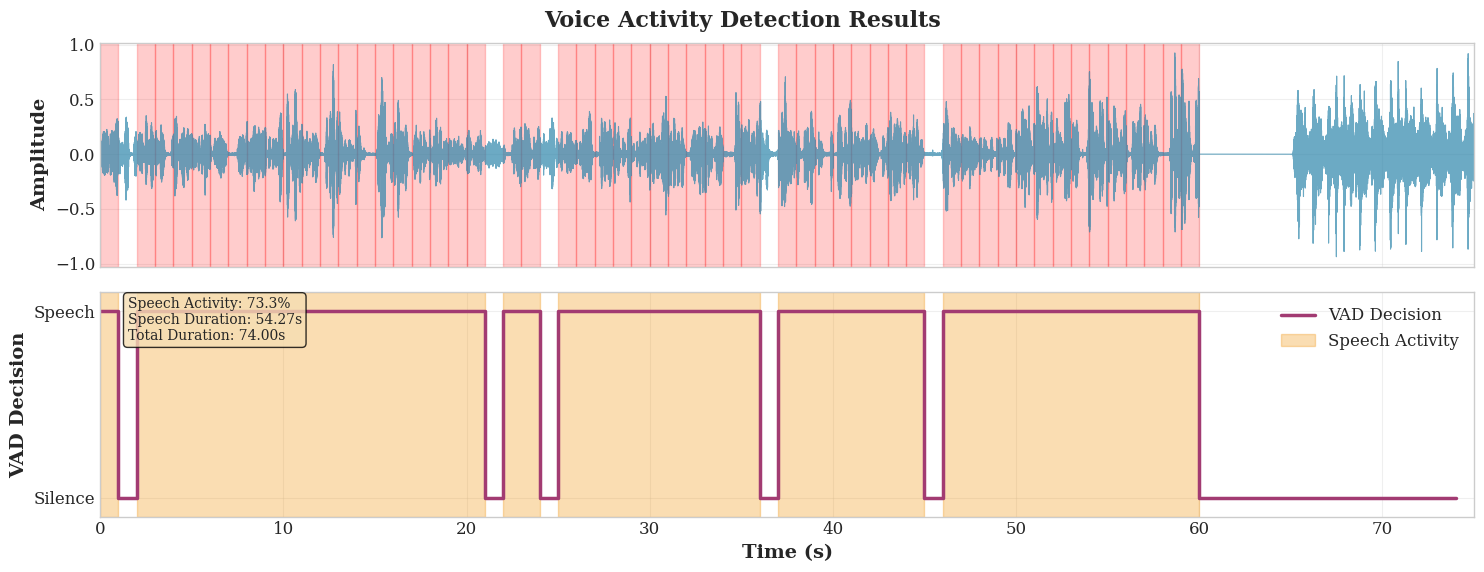

In [32]:
vad_labels = run_batch_inference("vad_model_quant_mfcc12_cls2_sigmoid.tflite", pdm_data_raw_norm_mfcc_no_first)
print("vad labels: ", vad_labels)
figure= plot_vad_results_academic(
    predictions=vad_labels,  # 你的标签列表，每个元素代表1秒的预测
    audio_data=pdm_data_raw.ravel(),
    sample_rate=8000,                    # 你的PCM采样率
    frame_shift=1000,                    # 1000ms = 1秒，每个标签的时间跨度
    title="Voice Activity Detection Results",
    figsize=(15, 6),
    save_path="my_vad_results.png"
)

# 三、说话人识别

In [33]:
# 获取中间层名字列表
interpreter = tf.lite.Interpreter(model_path='spk-OFFICIAL_ALL-NO_NOISE_hid512_9X12.tflite')
interpreter.allocate_tensors()
for t in interpreter.get_tensor_details():
    print(t['index'], t['name'])


0 serving_default_keras_tensor:0
1 arith.constant
2 tfl.pseudo_qconst
3 tfl.pseudo_qconst1
4 tfl.pseudo_qconst2
5 tfl.pseudo_qconst3
6 functional_1/re_lu_1/Relu;functional_1/conv2d_1/BiasAdd;functional_1/conv2d_1/convolution;functional_1/conv2d_1/Squeeze1
7 functional_1/average_pooling2d_1/AvgPool
8 functional_1/flatten_1/Reshape
9 functional_1/dense_1/MatMul;functional_1/dense_1/BiasAdd
10 StatefulPartitionedCall_1:0


/home/lidonghaowsl/miniconda3/envs/vesc2025-algo/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


分析说话人识别结果...
=== Speaker Diarization Statistics (5-Class) ===
Total segments: 75
Total duration: 75.0 seconds

Silence segments: 20 (26.7%)
XiaoXin: 7 segments (9.3%)
XiaoYuan: 3 segments (4.0%)
XiaoLai: 4 segments (5.3%)
XiaoSi: 4 segments (5.3%)
Others: 37 segments (49.3%)

生成可视化图表...
图像已保存至: speaker_diarization_5class.png


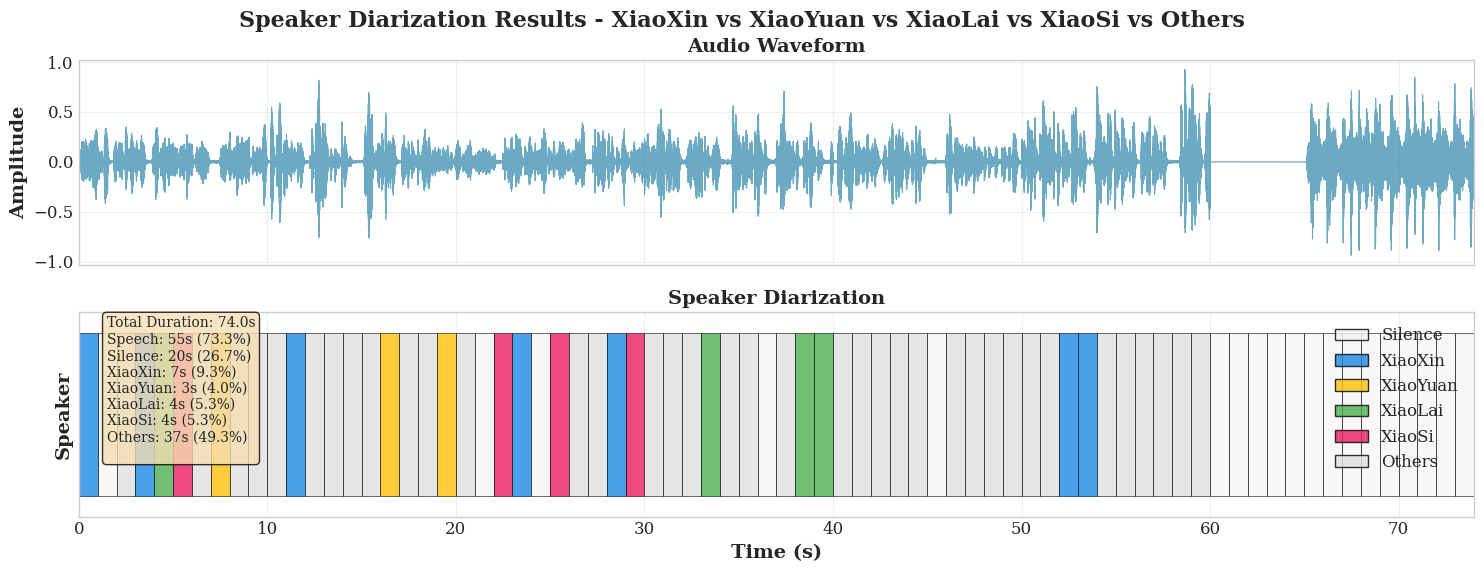

时间线图已保存至: speaker_timeline_5class.png


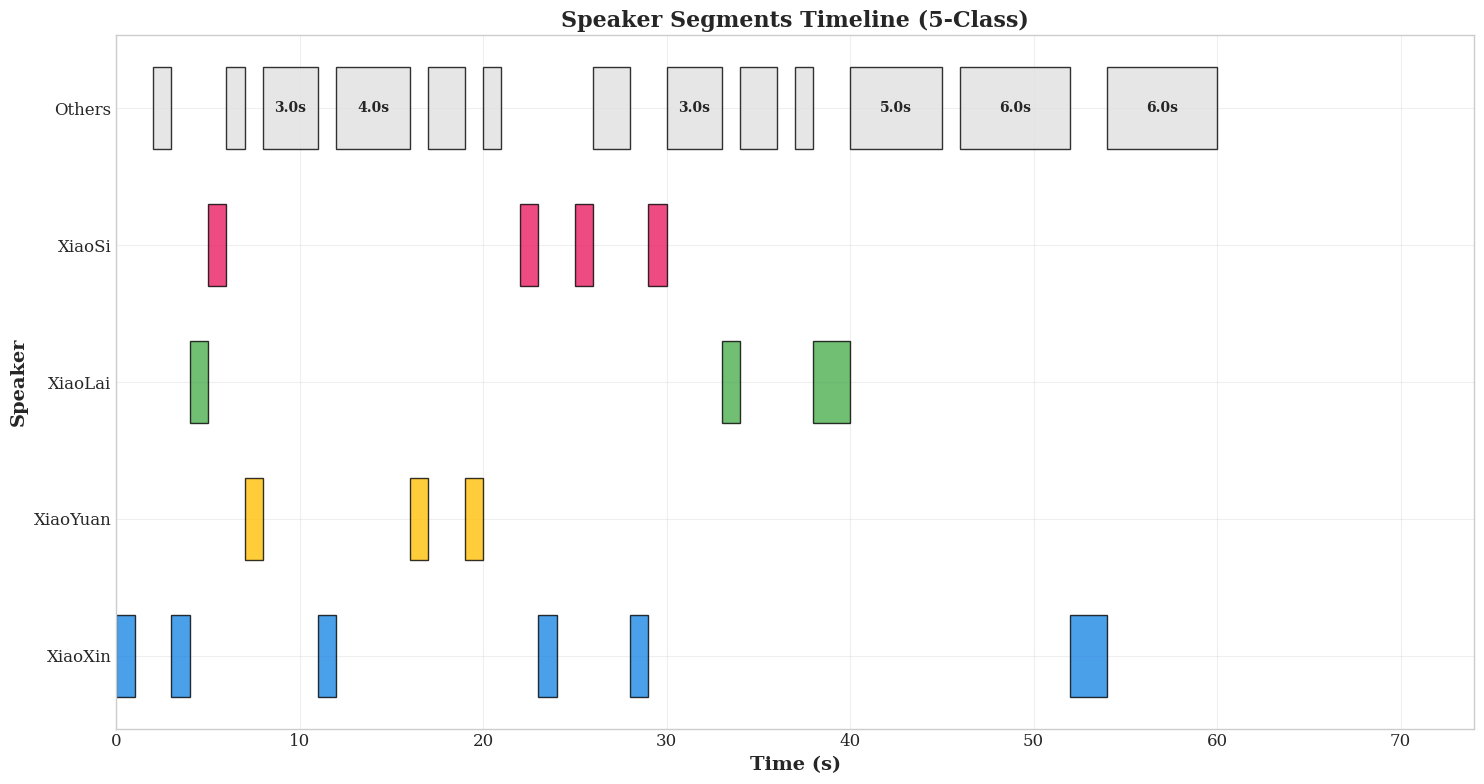

图像已保存至: speaker_diarization_smooth_5class.png


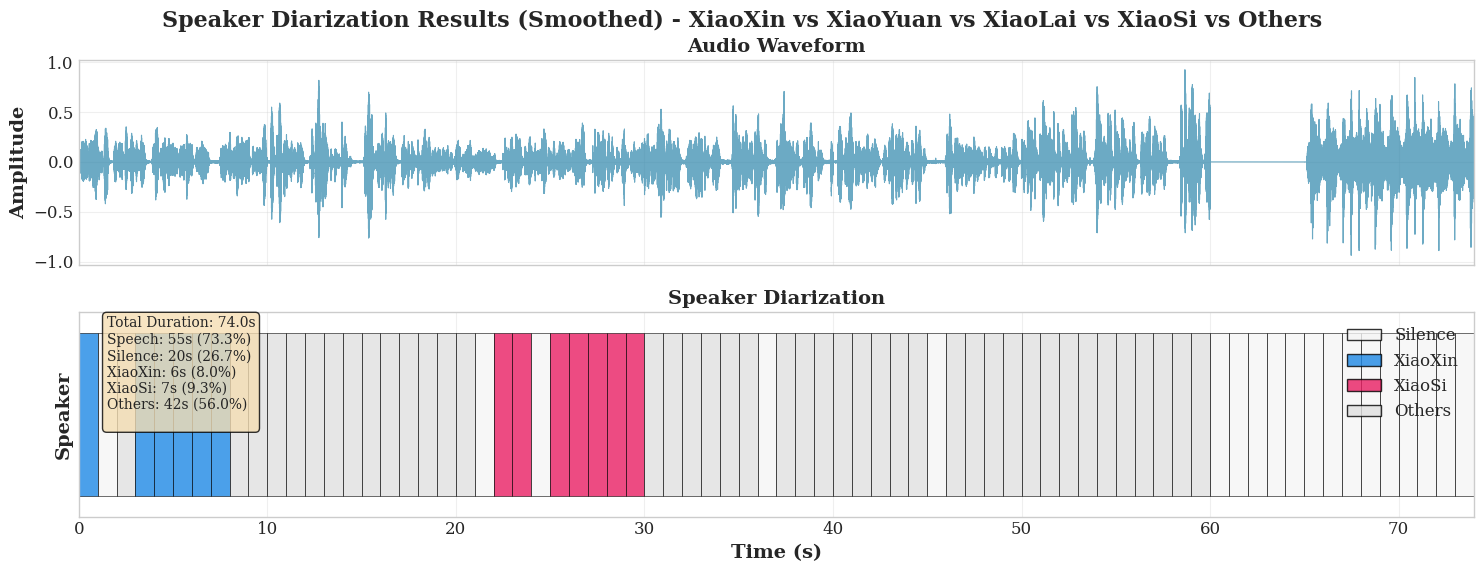

时间线图已保存至: speaker_timeline_smooth_5class.png


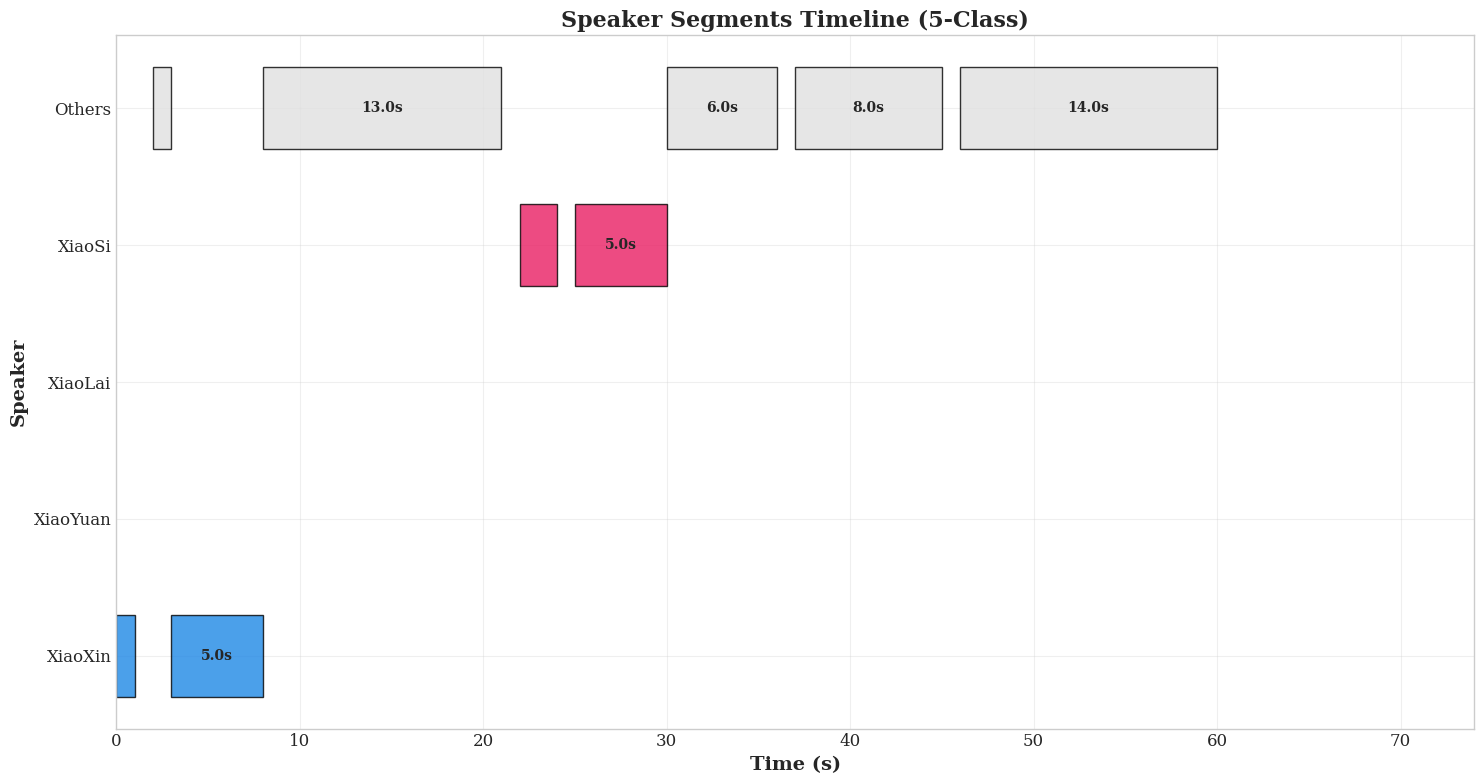

In [37]:
# 输出层的logits结果
spk_raw_embeddings = run_batch_inference_with_layer_output("spk-OFFICIAL_ALL-NO_NOISE_hid512_9X12.tflite", pdm_data_raw_norm_mfcc_no_first, output_layer_name="functional_1/dense_1/MatMul;functional_1/dense_1/BiasAdd")
# 将 VAD 为 0 的位置对应的spk替换为 nan
mask = vad_labels == 1  # shape: (120,)
mask = mask[:, np.newaxis]  # shape: (120, 1)，用于广播到 (120, 3)
spk_embeddings = np.where(mask, spk_raw_embeddings, np.nan)
# 指数平滑
spk_embeddings_smooth = exponential_smoothing_with_nan_restart(spk_embeddings, alpha=0.2)
spk_labels = argmax_label_ignore_nan(spk_embeddings)
spk_smooth_labels = argmax_label_ignore_nan(spk_embeddings_smooth)
# 使用可视化函数
print("分析说话人识别结果...")
analyze_speaker_statistics(spk_labels)

print("\n生成可视化图表...")
# 修改为：
figure = plot_speaker_diarization(
    speaker_labels=spk_labels,
    audio_data=pdm_data_raw.ravel(),
    sample_rate=8000,
    frame_shift=1000,
    title="Speaker Diarization Results - XiaoXin vs XiaoYuan vs XiaoLai vs XiaoSi vs Others",
    save_path="speaker_diarization_5class.png"
)

figure = plot_speaker_segments_timeline(
    speaker_labels=spk_labels,
    save_path="speaker_timeline_5class.png",
    figsize=(15, 8)  # 增加高度以容纳5个说话人
)

# 对于平滑后的结果：
figure = plot_speaker_diarization(
    speaker_labels=spk_smooth_labels,
    audio_data=pdm_data_raw.ravel(),
    sample_rate=8000,
    frame_shift=1000,
    title="Speaker Diarization Results (Smoothed) - XiaoXin vs XiaoYuan vs XiaoLai vs XiaoSi vs Others",
    save_path="speaker_diarization_smooth_5class.png"
)

figure = plot_speaker_segments_timeline(
    speaker_labels=spk_smooth_labels,
    save_path="speaker_timeline_smooth_5class.png",
    figsize=(15, 8)
)